# Sentimental Analysis: Airbnb Reviews 
##### Problematique : Are the customers feeling more negative or more positive toward the experience on Airbnb after COVID-19 outbreak?

In [89]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset

The dataset is from InsideAirbnb.  
'reviews2020-lang.csv' : the dataset was already cleaned before (too long to run)  
- contains only reviews from 2020
- include the column which contains the languange detected in the review

In [12]:
# ------ Load the data ------
reviews_2020 = pd.read_csv('reviews2020-lang.csv')

# ------ Keep only useful coliumns the data ------
reviews_2020 = reviews_2020[['listing_id', 'id', 'date', 'reviewer_id',
       'reviewer_name', 'comments', 'lang']]

In [15]:
# ------ preview the data ------
reviews_2020.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,lang
0,5396,588263108,2020-01-04,138392009,Patricia,..,arabic
1,5396,589499566,2020-01-06,28821240,Adrien,"Awesome, safe building, clean room, but more i...",english
2,5396,607910128,2020-02-19,26509433,Roberto,Great location and very helpful host.,english
3,5396,611549316,2020-02-27,8898065,Brenda,Location location location! This flat is perfe...,english
4,5396,612203113,2020-02-29,46597362,Carolyn,Great location. We were a bit bummed the wifi ...,english


In [19]:
# ------ shape of dataset ------
reviews_2020.shape

(124357, 7)

In [17]:
# ------ counts of the language in the dataset ------
reviews_2020['lang'].value_counts()

english        52861
french         44684
arabic         11041
spanish         4014
azerbaijani     3463
german          2207
dutch           1723
italian         1404
portuguese      1088
russian          757
danish           740
slovene           98
romanian          79
hungarian         77
swedish           25
greek             23
indonesian        23
norwegian         21
turkish           20
finnish            8
kazakh             1
Name: lang, dtype: int64

## Preprossesing: 

1. drop empty reviews
2. drop non english reviews 
3. drop autogenerated reviews


In [26]:
# ------ drop empty reviews ------
reviews_2020 = reviews_2020.dropna(subset=["comments"])

In [27]:
# ------ drop non english reviews ------
reviews_2020 = reviews_2020.loc[reviews_2020['lang']=='english']

In [28]:
# ------ check if its automatic post ------

def check_auto(input_text):
    if "This is an automated posting" in str(input_text):
        return 1
    else:
        return 0

In [46]:
# ------ drop autogenerated reviews ------
reviews_2020['auto']=reviews_2020['comments'].apply(lambda x: check_auto(x))
reviews_2020 = reviews_2020.loc[reviews_2020['auto']==0]
reviews_2020 = reviews_2020 [['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments',
       'lang']]

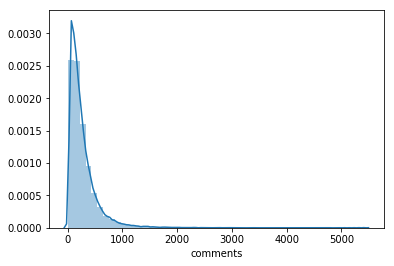

In [47]:
# ------ cleaned reviews length distribution ------
sns.distplot(reviews_2020["comments"].str.len())

In [48]:
# ------ cleaned dataset shape ------
reviews_2020.shape

(51207, 7)

## Vader sentimental analysis
Since the dataset is not labeled, we will use VADER model to add two columns in the dataset:
* sentiment: positive or negative  (decided by the compound score given by the model)
* score: the VADER compound score 

In [36]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [39]:
# ------ import VADER and print some examples ------

sid = SentimentIntensityAnalyzer()
for sentence in reviews_2020['comments'].values[:3]:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]))
    print('()')

Awesome, safe building, clean room, but more importantly, right in the CENTER of Paris, on the island, quick walk to the big central RER/subway exchange (Châtelet), I was pleasantly surprised. The photo makes it look bigger than it is but this is standard practice - it's an excellent room for 2.
compound: 0.9652, 
neg: 0.0, 
neu: 0.664, 
pos: 0.336, 
()
Great location and very helpful host. 
compound: 0.8016, 
neg: 0.0, 
neu: 0.357, 
pos: 0.643, 
()
Location location location! This flat is perfectly located. We were able to walk to pretty much everything and/or access the train very easily from its location. It a safe area, we have family in Paris that confirmed this as well. 

The flat itself is nice. Very modern. The bed for being a pull out coach is actually comfortable. I will say that the stair case to get to the flat are wooden almost spiral like stair case, if you have a lot of luggage they are not the  most friendly so please keep that in mind. Its pretty hazardous! There is no

In [49]:
# ------ add score column ------
reviews_2020['score'] = reviews_2020['comments'].apply(lambda x: sid.polarity_scores(x)['compound'])

In [50]:
# ------ generate the label by score ------

def compound_to_label(score):
    if score < 0:
        return "neg"
    else:
        return "pos"

In [52]:
# ------ add label column ------
reviews_2020['label']= reviews_2020['score'].apply(compound_to_label)

In [53]:
reviews_2020.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,lang,score,label
1,5396,589499566,2020-01-06,28821240,Adrien,"Awesome, safe building, clean room, but more i...",english,0.9652,pos
2,5396,607910128,2020-02-19,26509433,Roberto,Great location and very helpful host.,english,0.8016,pos
3,5396,611549316,2020-02-27,8898065,Brenda,Location location location! This flat is perfe...,english,0.9908,pos
4,5396,612203113,2020-02-29,46597362,Carolyn,Great location. We were a bit bummed the wifi ...,english,0.8917,pos
6,5396,614805142,2020-03-06,269002087,Lilla,This appartment is very nice and clean. It's r...,english,0.9711,pos


In [205]:
# ------ count labels ------
reviews_2020['label'].value_counts()

pos    49808
neg     1399
Name: label, dtype: int64

In [57]:
# ------ labels percentage in the dataset ------
reviews_2020['label'].value_counts()/len(reviews_2020['label'])

pos    0.97268
neg    0.02732
Name: label, dtype: float64

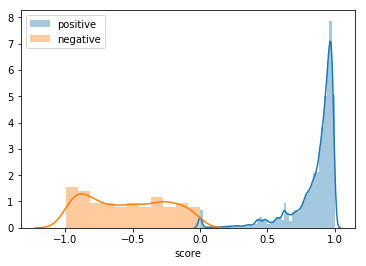

In [56]:
# ------ plot the distribution of the scores for positive and negative reviews  ------
sns.distplot(reviews_2020.loc[reviews_2020['label']=='pos', 'score'])
sns.distplot(reviews_2020.loc[reviews_2020['label']=='neg', 'score']);
plt.legend(labels=['positive', 'negative'])

### Examples of Positive and Negative Reviews

In [61]:
# ------ Print the most positive reviews  ------

posi = reviews_2020.loc[reviews_2020['label']=='pos'][['comments','score']].sort_values('score',ascending=False)
i=0
for element in posi['comments']:
    i = i++1
    if i < 3:
        print(i)
        print(element)
        print("-------")

1
AMAZING PLACE & So Much More!!

The Paris flat on it own is very nice, clean, in a great location, with a very responsive and accomidable host; but that pales in comparison to to the kindness and extra effort and care that the host provides to guests. 

The flat feels like a home from the minute that walk in. I was traveling from the US with my wife and 3 small children through Paris as part of a greater European adventure. The host, Harout, had excellent communication with us leading up to our arrival. He then met us onsite to show us in, show us around (not only the apartment but the building as well), and helped us settle in and showed us where everything was and how everything worked. He provided directions to local attractions and transportation options and answered any and all questions that we had. He was not in a rush, it was clear that he was going to stay as long as needed until we felt absolutely comfortable in our new surroundings. The flat itself looks exactly like the p

In [62]:
# ------ postive reviews and score  ------
posi.head()

,comments,score
36462,AMAZING PLACE & So Much More!!\n\nThe Paris fl...,0.9996
858,A brief summary for those who won't take the t...,0.9994
16122,Check in: \nThere was a slight inconvenience d...,0.9992
6342,I fell in love with the apartment from the ver...,0.9992
101271,"I was thinking I am a good host, but Alix is t...",0.9992


In [63]:
# ------ mean score of positive reviews ------

reviews_2020.loc[reviews_2020['label']=='pos']['score'].mean()

0.8472871044812053

In [66]:
# ------ mean score of negative reviews ------
reviews_2020.loc[reviews_2020['label']=='neg']['score'].mean()

-0.5461503931379562

### Word Cloud of Positive and Negative Reviews

In [72]:
import re
from collections import Counter

# ------ stop words from nltk ------
from nltk.corpus import stopwords
stopwords_en = set(stopwords.words("english"))

In [71]:
# import and use wordcloud
from wordcloud import WordCloud

### WordCloud: Positive

In [73]:
# ------ cleaned the stop words ------
pos = reviews_2020.loc[reviews_2020['label']=='pos']['comments']
pattern = "[A-Za-zÀ-ÿ0-9]+(?:'[st])?"

pos_c = Counter()
pos.apply(lambda x: pos_c.update(re.findall(pattern, x.lower())))

for stop in stopwords_en:
    del pos_c[stop]

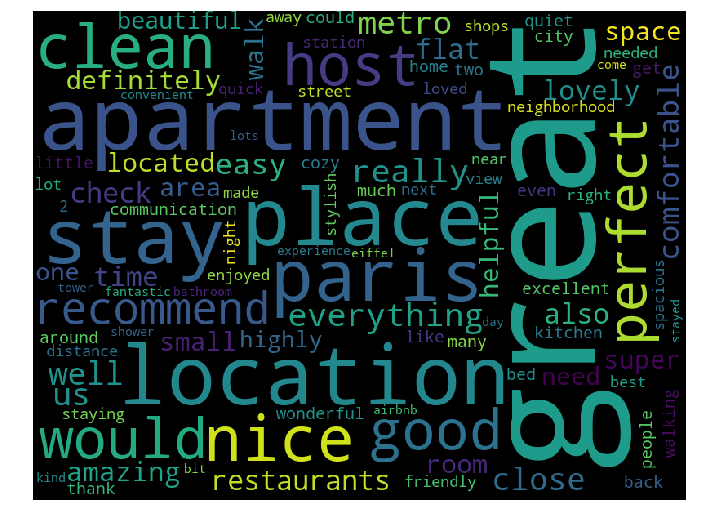

In [74]:
# ------ generate wordcloud ------
wc = WordCloud(max_words=100, stopwords=stopwords_en, normalize_plurals=True, width=800, height=600)
wc.generate_from_frequencies(pos_c)

# display de word cloud
plt.figure(figsize=(12,9))
plt.axis("off")
plt.imshow(wc);

### Wordcloud: Negative

In [77]:
# ------ cleaned the stop words ------
neg = reviews_2020.loc[reviews_2020['label']=='neg']['comments']
# get all words
pattern = "[A-Za-zÀ-ÿ0-9]+(?:'[st])?"

neg_c = Counter()
neg.apply(lambda x: neg_c.update(re.findall(pattern, x.lower())))

for stop in stopwords_en:
    del neg_c[stop]

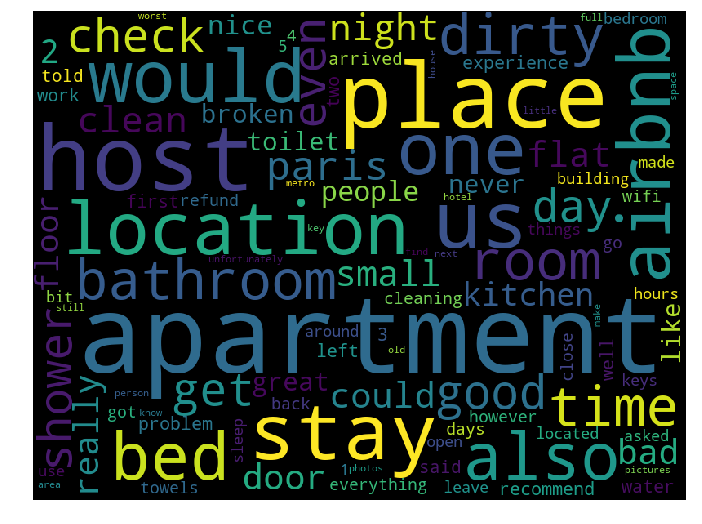

In [80]:
# ------ generate wordcloud ------
wc = WordCloud(max_words=100, stopwords=stopwords_en, normalize_plurals=True, width=800, height=600)
wc.generate_from_frequencies(neg_c)

# display de word cloud
plt.figure(figsize=(12,9))
plt.axis("off")
plt.imshow(wc);

## Sentiment Polarity
1. The distribution of 4 VADER scores: Neutrality, Positivity, Negativity, Compound

In [81]:
# ------ create a list containing each review  ------
reviews_f = [r for r in reviews_2020['comments']]

In [82]:
# ------ get the score from VADER ------
pscores = [sid.polarity_scores(comment) for comment in reviews_f]

In [83]:
import pylab as pl
from pandas import *

Text(0.5,1,'Neutrality')

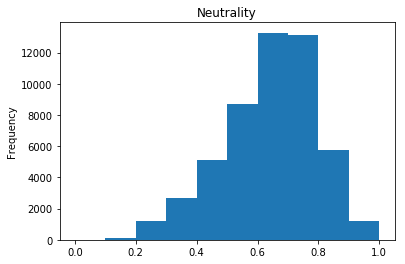

In [84]:
# ------ Plot neutrality score distribuiton ------
pd.Series([score['neu'] for score in pscores]).plot(kind='hist')
pl.title("Neutrality")

Text(0.5,1,'Positivity')

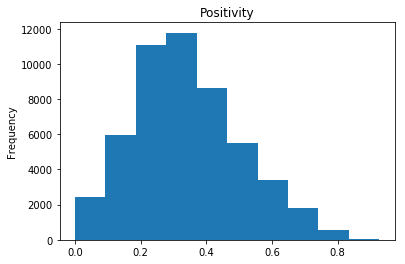

In [85]:
# ------ Plot Positivity score distribuiton ------
pd.Series([score['pos'] for score in pscores]).plot(kind='hist')
pl.title("Positivity")

Text(0.5,1,'Negativity')

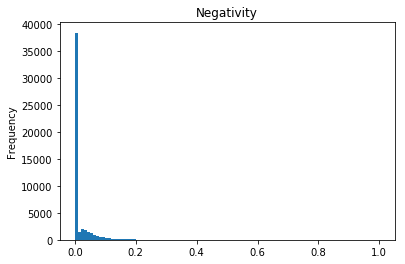

In [86]:
# ------ Plot Negativity score distribuiton ------
pd.Series([score['neg'] for score in pscores]).plot(kind='hist', bins=100)
pl.title("Negativity")

Text(0.5,1,'Compound')

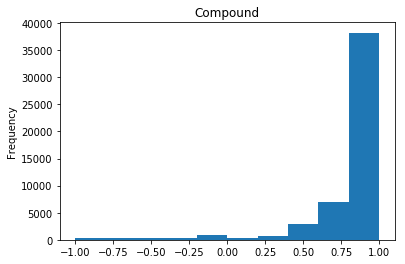

In [87]:
# ------ Plot Compound score distribuiton ------
pd.Series([score['compound'] for score in pscores]).plot(kind='hist')
pl.title("Compound")

### Save the data for topic Modelling 
"reviews2020-label.csv":
* only contains reviews in 2020
* dataset cleaned (drop empty reviews, drop non-english reviews, drop automatic posts)
* labelled and scored by VADER model ---> 'label' & 'score' columns

In [90]:
reviews_2020.to_csv("reviews2020-label.csv")